In [5]:
import msprime
from trails.cutpoints import cutpoints_ABC
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
import pandas as pd
import numpy as np

n_int_AB = 1
n_int_ABC = 1

# mu = 2e-8
# g = 25
# N_AB = 30_000*2*mu
# N_ABC = 30_000*2*mu
# N_ref = N_ABC
# t_1 = 60_000/g*mu
# t_2 = (600_000-t_1)/g*mu
# t_3 = (20_000_000-t_2)/g*mu
# t_A = t_1
# t_B = t_1
# t_C = t_1+t_2
# t_m = t_1-40_000/g*mu
# t_upper = t_3-cutpoints_ABC(n_int_ABC,  1/N_ABC)[-2]
# t_out = t_1+t_2+t_3+2*N_ABC
# r = 1e-8/mu
# mu = mu/mu
# m = 0.20
# seed = 2

mu = 1.25e-8
g = 29
N_AB = 7_000*2*mu
N_ABC = 7_000*2*mu
N_ref = N_ABC
t_1 = 62_041/g*mu
t_2 = (580_000-t_1)/g*mu
t_3 = (6_000_000-t_2)/g*mu
t_A = t_1
t_B = t_1
t_C = t_1+t_2
t_m = t_1-54_000/g*mu
t_upper = t_3-cutpoints_ABC(n_int_ABC,  1/N_ABC)[-2]
t_out = t_1+t_2+t_3+2*N_ABC
r = 1e-8/mu
mu = mu/mu
m = 0.02

seed = 2

In [7]:
m*(2/3)*np.exp(-(t_2+t_m)/(N_AB))+(1-m)*(2/3)*np.exp(-(t_2)/(N_AB))

0.1597046950279733

In [8]:
from trails.optimizer import trans_emiss_calc_introgression

# t_A_bis = 9.760626404331717e-06	
# t_B_bis = 1.3972830597438445e-05	
# t_C_bis = 0.00042886096228597425	
# t_2_bis = 0.0004058914048049397	
# t_upper_bis = 0.0048043513891500795	
# t_m_bis = 1.5577290776046196e-05	
# N_AB_bis = 0.00046680278025359567	
# N_ABC_bis = 0.000465186413352549	
# r_bis = 0.4066869848559081	
# m_bis = 0.0530950550095846
# cut_ABC = cutpoints_ABC(n_int_ABC, 1)
# t_out_bis = (((t_A_bis+t_B_bis)/2+t_2_bis)+t_C_bis)/2 + cut_ABC[n_int_ABC-1]*N_ABC_bis + t_upper_bis + 2*N_ABC_bis
# transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc_introgression(
#     t_A_bis, t_B_bis, t_C_bis, t_2_bis, t_upper_bis, t_out_bis, t_m_bis,
#     N_AB_bis, N_ABC_bis, r_bis, m_bis, n_int_AB, n_int_ABC)

transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc_introgression(
    t_1, t_1, t_1+t_2, t_2, t_upper, t_out, t_m,
    N_AB, N_ABC, r, m, n_int_AB, n_int_ABC)

starting

array([0.74514198, 0.07985235, 0.07985235, 0.07985235, 0.01530097])

In [9]:
n_sites = 1_000_000

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
demography.add_population(name="B_anc", initial_size=N_AB, initially_active=False)
demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1+t_2-t_C)
demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_admixture(time = t_1-t_m, derived="B", ancestral=["B_anc", "C"], proportions=(1-m, m))
demography.add_population_split(time=t_1, derived=["A", "B_anc"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

# demography.debug()

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed=seed
)



In [10]:
# Add mutations
dct = {v: k for k, v in observed_states.items()}

mutated_ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
sim_genome = np.random.choice(nochange_lst, n_sites)

mut_lst = []
mut_loc = []
for variant in mutated_ts.variants():
    mut_loc.append(variant.site.position)
    mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))

for i in range(len(mut_loc)):
    sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]

E = sim_genome

In [11]:
# from trails.optimizer import loglik_wrapper

# loglik = loglik_wrapper(transitions, emissions, starting, [E])

# loglik

In [12]:
# from numba.typed import List
# from trails.read_data import get_idx_state
# from trails.optimizer import forward

# order = List()
# for i in range(624+1):
#     order.append(get_idx_state(i))

# alpha = forward(transitions, emissions, starting, E, order)


In [13]:
from trails.optimizer import post_prob_wrapper

postprobs = post_prob_wrapper(transitions, emissions, starting, [E])


In [14]:
postprobs_df = pd.DataFrame(postprobs[0], columns=[str(i) for i in hidden_states.values()])
postprobs_df = postprobs_df[0:1000000]

In [15]:
postprobs_df

,"(0, 0, 0)","(1, 0, 0)","(2, 0, 0)","(3, 0, 0)","(4, 0, 0)"
0,0.990630,0.003500,0.002923,0.002923,0.000024
1,0.990634,0.003498,0.002922,0.002922,0.000024
2,0.990638,0.003497,0.002921,0.002920,0.000024
3,0.990642,0.003496,0.002919,0.002919,0.000024
4,0.990646,0.003495,0.002918,0.002918,0.000024
...,...,...,...,...,...
999995,0.536480,0.279510,0.082422,0.095913,0.005674
999996,0.536390,0.279524,0.082460,0.095949,0.005677
999997,0.536300,0.279539,0.082497,0.095984,0.005679
999998,0.536211,0.279553,0.082535,0.096020,0.005682


In [16]:
# import demesdraw
# import matplotlib.pyplot as plt

In [17]:
# graph = msprime.Demography.to_demes(demography)
# fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
# demesdraw.tubes(graph, ax=ax, seed=1)
# plt.show()

In [18]:
# ts.draw_svg(y_axis=True)

In [19]:
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)
cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_AB_2 = np.array([t_1-t_m]+list(cut_AB)[1::])

left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        if mint>=(t_1+t_2):
            state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        else:
            state = (4, (mint>cut_AB_2).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (5, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
        print((find_re, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1))
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)

In [20]:
set(tree_state)

{(0, 0, 0), (1, 0, 0), (2, 0, 0), (3, 0, 0), (4, 0, 0)}

In [21]:
df = pd.DataFrame()
df['state'] = [str(i) for i in tree_state]
df['start'] = left_lst
df['end'] = right_lst
df

,state,start,end
0,"(0, 0, 0)",0.0,29.0
1,"(0, 0, 0)",30.0,1180.0
2,"(0, 0, 0)",1181.0,1371.0
3,"(0, 0, 0)",1372.0,3160.0
4,"(0, 0, 0)",3161.0,4803.0
...,...,...,...
846,"(0, 0, 0)",994572.0,995896.0
847,"(0, 0, 0)",995897.0,998463.0
848,"(0, 0, 0)",998464.0,998898.0
849,"(0, 0, 0)",998899.0,999065.0


In [22]:
%%R -i df -i n_sites

library(tidyverse)

tibble(df) %>%
    group_by(state) %>%
    summarize(total = sum(end-start)/n_sites)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# A tibble: 5 × 2
  state      total
  <chr>      <dbl>
1 (0, 0, 0) 0.726 
2 (1, 0, 0) 0.0697
3 (2, 0, 0) 0.0441
4 (3, 0, 0) 0.0721
5 (4, 0, 0) 0.0870


In [23]:
%%R -i postprobs_df

postprobs_tab <- 
    tibble(postprobs_df) %>% 
    mutate(
        pos = 0:(n()-1)
    )  %>% 
    pivot_longer(-pos)

In [24]:
%%R

true_tab <- tibble(df) %>% 
    mutate(
        groupid = data.table::rleid(state)
    ) %>% 
    group_by(groupid, state) %>%
    summarize(
        start = min(start),
        end = max(end)
    )

true_tab %>% 
    filter(state == '(4, 0, 0)') %>%
    mutate(length = end-start)

`summarise()` has grouped output by 'groupid'. You can override using the `.groups` argument.
# A tibble: 3 × 5
# Groups:   groupid [3]
  groupid state      start    end length
    <int> <chr>      <dbl>  <dbl>  <dbl>
1      73 (4, 0, 0) 723814 734037  10223
2      75 (4, 0, 0) 734182 804574  70392
3      77 (4, 0, 0) 809251 815698   6447


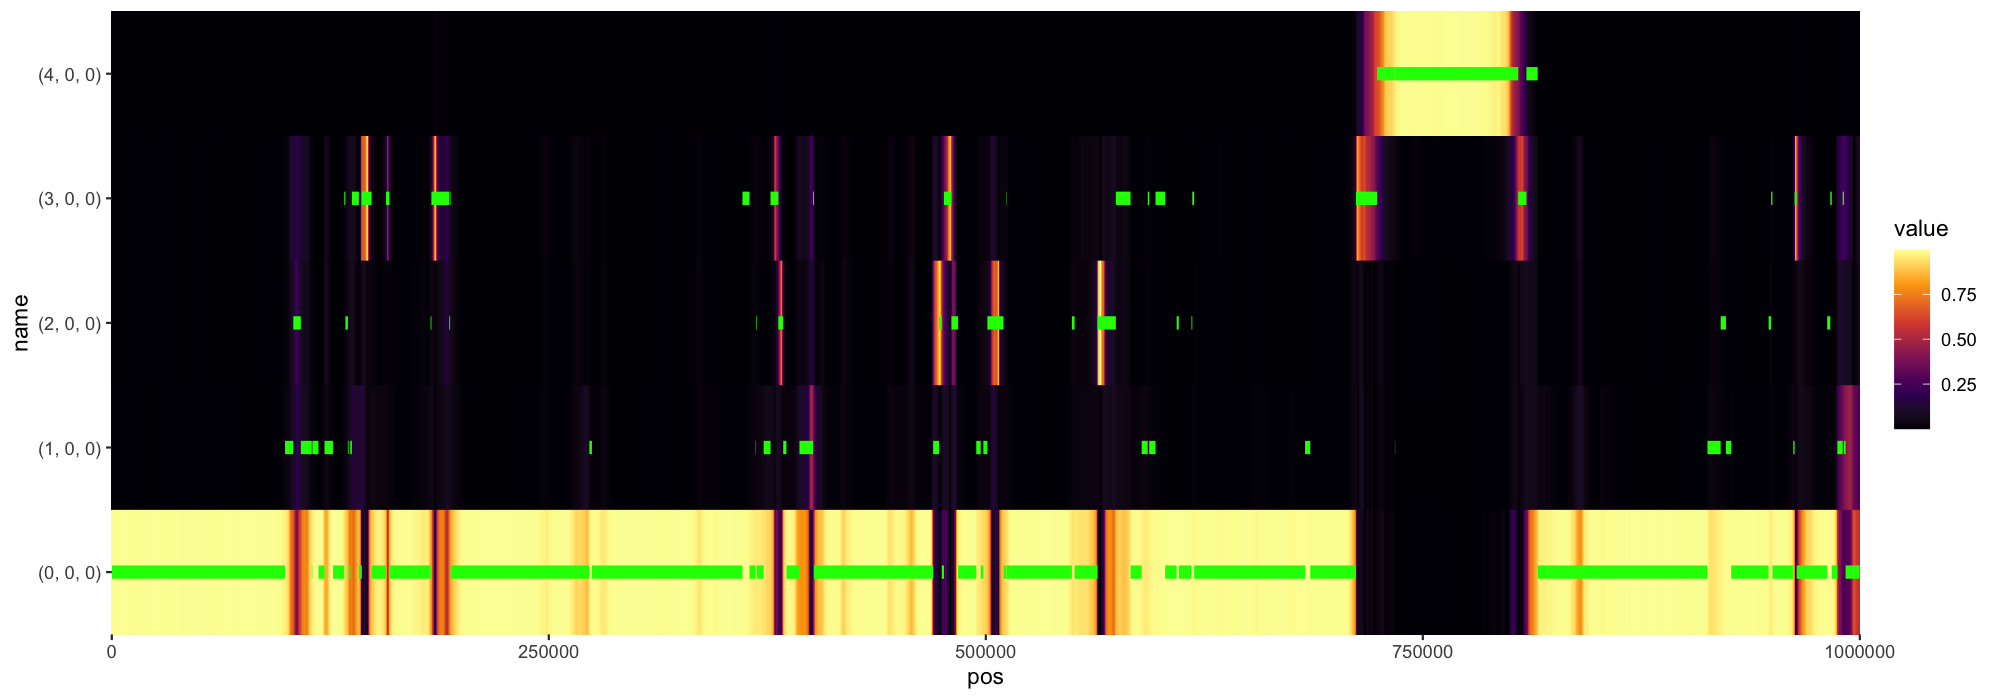

In [25]:
%%R -w 2000 -h 700 -r 150

postprobs_tab %>% 
    ggplot() +
    geom_tile(aes(pos, name, fill = value, color = value)) +
    geom_segment(aes(x = start, xend = end, y = state, yend = state), color = 'green', size = 3, data = true_tab) +
    scale_x_continuous(limits = c(0, 1000000), expand = c(0, 0)) +
    scale_y_discrete(expand = c(0, 0)) +
    scale_color_viridis_c(option = 'inferno') +
    scale_fill_viridis_c(option = 'inferno')